<a href="https://colab.research.google.com/github/vedasri2511/ML_153/blob/main/ML_Assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Research paper: "Improvement and Parallelism of k-Means Clustering Algorithm"**



1.Identify the research gap for improvement.

While this paper contributes to improving the efficiency of k-means clustering through refined initialization and parallelism, several gaps remain unaddressed. The study does not investigate the quality and validity of the clusters, particularly in the presence of outliers or non-spherical data distributions. It also overlooks clustering in dynamic or streaming environments, where data evolves continuously. Furthermore, challenges posed by high-dimensional data and the suitability of alternative distance measures are not discussed. Finally, the parallel approach is limited to shared-memory systems and does not extend to modern large-scale distributed platforms. These gaps suggest opportunities for future research to enhance both the robustness and applicability of k-means clustering.

Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Load the dataset

In [2]:
# Load dataset
df = pd.read_csv("/content/Mall_Customers.csv")
print(df.head())

# Drop CustomerID (not useful for clustering)
df = df.drop("CustomerID", axis=1)


   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


Preprocessing

In [3]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male=1, Female=0

scaler = StandardScaler()
X = scaler.fit_transform(df)

print(X[:5])


[[ 1.12815215 -1.42456879 -1.73899919 -0.43480148]
 [ 1.12815215 -1.28103541 -1.73899919  1.19570407]
 [-0.88640526 -1.3528021  -1.70082976 -1.71591298]
 [-0.88640526 -1.13750203 -1.70082976  1.04041783]
 [-0.88640526 -0.56336851 -1.66266033 -0.39597992]]


Baseline K-Means

Inertia (SSE): 333.2636702333685
Silhouette Score: 0.30444133395839884


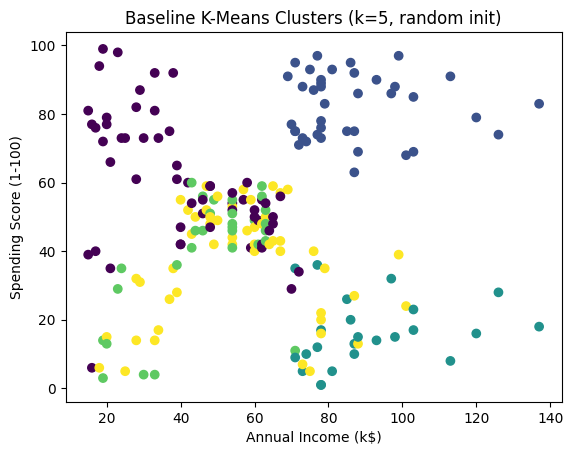

In [4]:
# Run baseline k-means
kmeans = KMeans(n_clusters=5, init='random', n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(X)

# Evaluate
print("Inertia (SSE):", kmeans.inertia_)
print("Silhouette Score:", silhouette_score(X, labels))

# Visualize clusters
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=labels, cmap='viridis')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Baseline K-Means Clusters (k=5, random init)")
plt.show()


# **Hyperparameter Tuning**

(a) Elbow Method (Finding Optimal k)

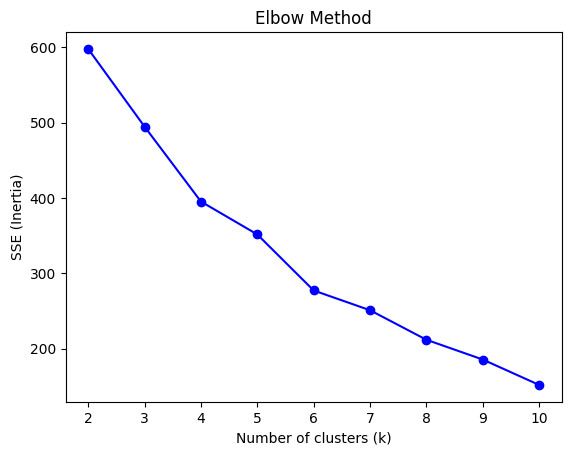

In [5]:
sse = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(X)
    sse.append(km.inertia_)

plt.plot(K, sse, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")
plt.show()


(b) Silhouette Score for Different k

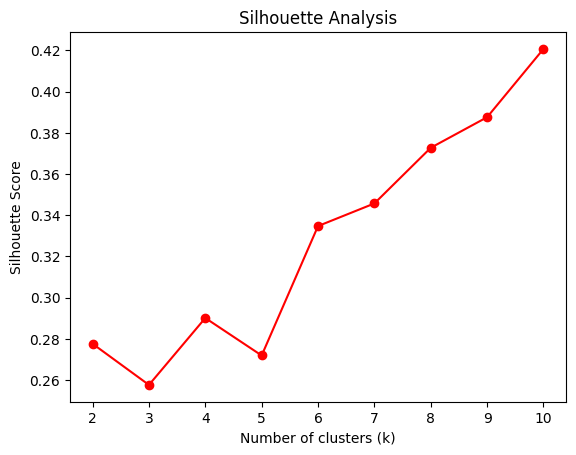

In [6]:
sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

plt.plot(K, sil_scores, 'ro-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()


(c) Compare Init Methods & n_init

In [7]:
# Compare random vs k-means
for init in ['random', 'k-means++']:
    km = KMeans(n_clusters=5, init=init, n_init=10, max_iter=300, random_state=42)
    labels = km.fit_predict(X)
    print(f"Init={init} -> Inertia={km.inertia_}, Silhouette={silhouette_score(X, labels)}")

# Try more initializations
for n in [10, 20, 30]:
    km = KMeans(n_clusters=5, init='k-means++', n_init=n, max_iter=300, random_state=42)
    labels = km.fit_predict(X)
    print(f"n_init={n} -> Inertia={km.inertia_}, Silhouette={silhouette_score(X, labels)}")


Init=random -> Inertia=333.2636702333685, Silhouette=0.30444133395839884
Init=k-means++ -> Inertia=331.3098837641085, Silhouette=0.3040600988258827
n_init=10 -> Inertia=331.3098837641085, Silhouette=0.3040600988258827
n_init=20 -> Inertia=327.3514986423793, Silhouette=0.31437614343154285
n_init=30 -> Inertia=327.3514986423793, Silhouette=0.31437614343154285


# Final Model & Visualization

Final Model Inertia: 327.3514986423793
Final Model Silhouette Score: 0.31437614343154285


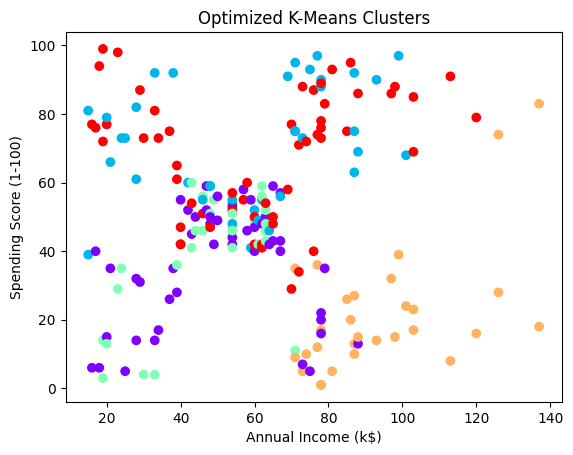

In [8]:
# Best model
final_kmeans = KMeans(n_clusters=5, init='k-means++', n_init=30, max_iter=500, random_state=42)
final_labels = final_kmeans.fit_predict(X)

# Evaluation
print("Final Model Inertia:", final_kmeans.inertia_)
print("Final Model Silhouette Score:", silhouette_score(X, final_labels))

plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=final_labels, cmap='rainbow')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Optimized K-Means Clusters")
plt.show()


# **1. Feature Importance in K-Means**
K-means doesn’t directly give “feature importance” (since it’s unsupervised), but you can infer importance using:

Variance of features within clusters – If a feature has high variation between clusters, it’s important.

Cluster centers (centroids) – The centroid values show how each feature contributes to separating clusters.

Dimensionality reduction (PCA) – Shows which features explain most variance in the data.

# **2. Plotting Feature Importance**
(a) Look at Cluster Centers

In [9]:
# Get cluster centers for final model
centers = final_kmeans.cluster_centers_

# Put back into a DataFrame with feature names
centers_df = pd.DataFrame(centers, columns=df.columns)

print("Cluster Centers:\n", centers_df)


Cluster Centers:
      Gender       Age  Annual Income (k$)  Spending Score (1-100)
0 -0.886405  0.713481           -0.390346               -0.535899
1  1.128152 -0.749226           -0.088905                0.796539
2  1.128152  1.317944           -0.525757               -0.445893
3  0.572412  0.003341            1.282967               -1.101461
4 -0.886405 -0.750475           -0.005017                0.697956


(b) Variance Across Clusters (Importance)

Feature Importance:
 Gender                    1.055388
Age                       0.828334
Spending Score (1-100)    0.687879
Annual Income (k$)        0.516956
dtype: float64


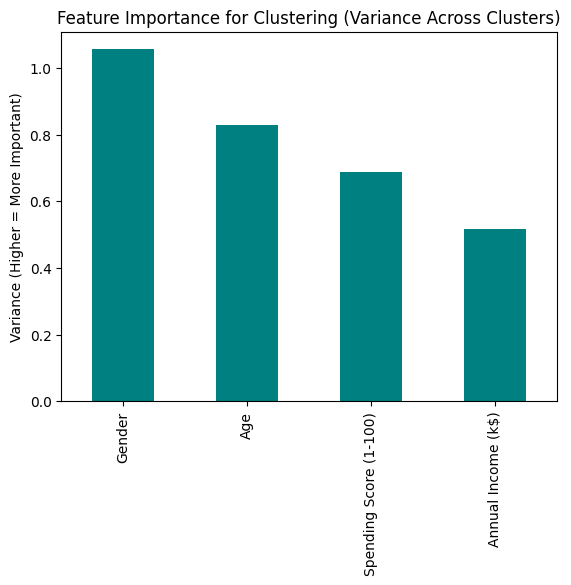

In [10]:
# Calculate variance of cluster centers across clusters
feature_importance = centers_df.var().sort_values(ascending=False)

print("Feature Importance:\n", feature_importance)

feature_importance.plot(kind='bar', color='teal')
plt.title("Feature Importance for Clustering (Variance Across Clusters)")
plt.ylabel("Variance (Higher = More Important)")
plt.show()


(c) PCA for Feature Contribution

Explained Variance Ratio: [0.33690046 0.26230645]


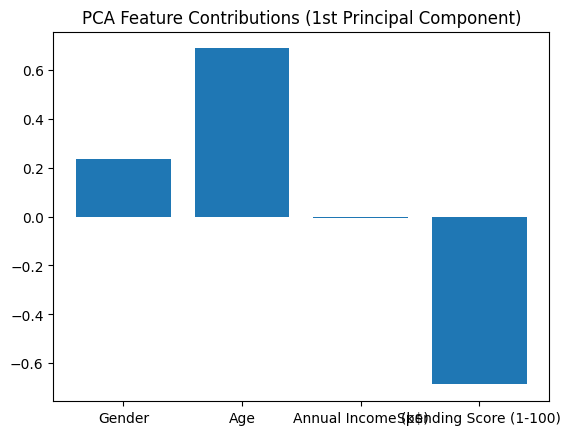

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

plt.bar(range(len(pca.components_[0])), pca.components_[0], tick_label=df.columns)
plt.title("PCA Feature Contributions (1st Principal Component)")
plt.show()
